In [1]:
import sys

PWD = '../..'
sys.path.append(PWD)

DATASET_PATH = '../../data/dataset/dataset.pkl'

import pickle
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from src.cfd import CFD
from src.diff_hist import plot_diff_hist_stats, get_gauss_stats

In [2]:
PLANE = 2
CHANNEL = 11

with open(DATASET_PATH, 'rb') as file:
    dataset = pickle.load(file)
    
all_X, all_y = dataset[(PLANE, CHANNEL)][0], dataset[(PLANE, CHANNEL)][1]
all_X.shape, all_y.shape

((26295, 24), (26295,))

In [3]:
x_time = np.arange(0, 24 / 7.8, 1 / 7.8)
x_time.shape

(24,)

# Preprocess

In [4]:
N_BASELINE = 8

In [5]:
all_X -= np.mean(all_X[:, :N_BASELINE], axis=1)[:, None]
all_X /= all_X.max(axis=1)[:, None]

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1234)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((16828, 24), (4208, 24), (5259, 24), (16828,), (4208,), (5259,))

# Utils

In [7]:
def plot_difference_hist(y_true, y_pred, plane, channel, hist_range=(-0.5, 0.5), n_bins=100):
    mu, std = plot_diff_hist_stats(y_true, y_pred, show=False, n_bins=n_bins, hist_range=hist_range, plot_gauss=True)

    plt.title(f'Diff histogram (p: {plane}, ch: {channel}), mean={mu:0.4f}, std={std:0.4f}')
    plt.show()
    return std

def train_model(model, name, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, lr=0.001, train=True, n_epochs=1000, verbose=1, batch_size=2048, lr_patience=None, es_patience=None, loss_weights=None):
    model.compile(loss='mse', optimizer=optimizers.Adam(lr), loss_weights=loss_weights)

    model_callbacks = []
    model_callbacks.append(callbacks.ModelCheckpoint(filepath=f'model_weights/basic_tests/{name}/weights', save_best_only=True, save_weights_only=True))
    if es_patience is not None:
        model_callbacks.append(callbacks.EarlyStopping(patience=es_patience))
    if lr_patience is not None:
        model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=lr_patience))
    
    if train:
        history = model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=model_callbacks).history
        pd.DataFrame(history).to_csv(f'model_weights/basic_tests/{name}/loss_log.csv')

    model.load_weights(f'model_weights/basic_tests/{name}/weights')
    history = pd.read_csv(f'model_weights/basic_tests/{name}/loss_log.csv')
    
    return history

def plot_history(history: dict[str, np.array], title: str, ymax: float = None, figsize: tuple[float, float] = (8, 6)):
    plt.figure(figsize=figsize)

    X = np.arange(1, len(history['loss']) + 1)

    plt.plot(X, history['loss'], label='train')
    plt.plot(X, history['val_loss'], label='validation')

    if ymax is not None:
        plt.ylim(0, ymax)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    # plt.title(f"val loss {history[f'val_loss'].values[-1]:0.4f} (min: {min(history[f'val_loss'].values):0.4f})")
    plt.title(f"validation loss: {min(history[f'val_loss'].values):0.4f}")
    plt.grid()
    plt.legend()

    plt.suptitle(title)
    plt.show()

# CFD

In [8]:
cfd = CFD(n_baseline=N_BASELINE, threshold=0.3)

y_pred = []
for x in X_val:
    y_pred.append(cfd.predict(x_time, x))
    
y_pred = np.array(y_pred)
y_pred.shape

(4208,)

In [9]:
print(f'{mean_squared_error(y_val, y_pred) * 1000}:0.4f')

6.765007391721422:0.4f


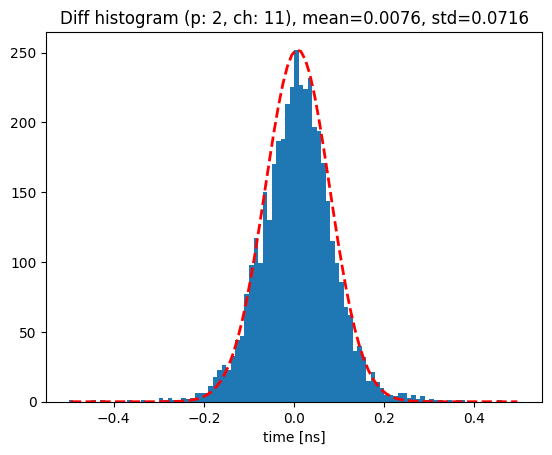

In [10]:
std_cfd = plot_difference_hist(y_val, y_pred, PLANE, CHANNEL)

# MLP 1

In [11]:
mlp_1_name = model_name = 'MLP 1'
model = keras.Sequential([
    layers.Input(24),
    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.1, train=False, n_epochs=3000, lr_patience=50, es_patience=400, loss_weights=1000)

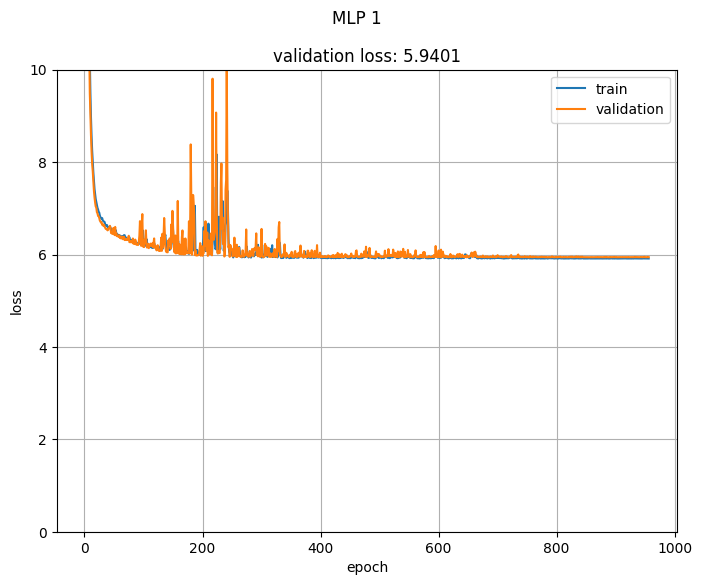

In [12]:
plot_history(history, model_name, ymax=10)

132/132 [==============================] - 1s 1ms/step


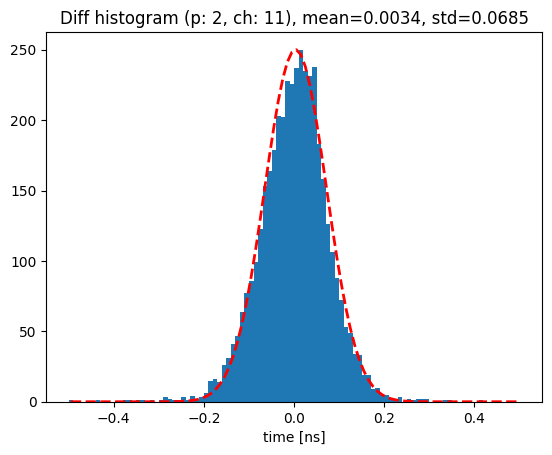

In [13]:
y_pred = model.predict(X_val)[:, 0]
std_1 = plot_difference_hist(y_val, y_pred, PLANE, CHANNEL)

# MLP 2

In [14]:
mlp_2_name = model_name = 'MLP 2'
model = keras.Sequential([
    layers.Input(24),
    
    layers.Dense(24, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(6, activation='relu'),
    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.01, train=False, n_epochs=3000, lr_patience=50, es_patience=400, loss_weights=1000)

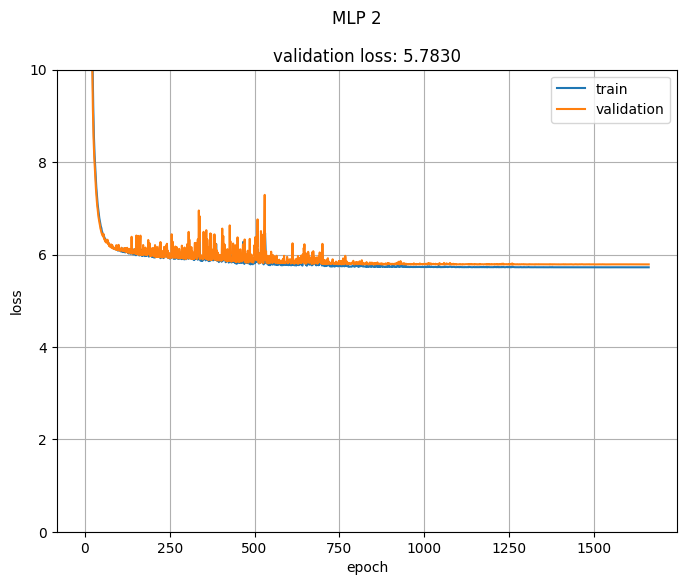

In [15]:
plot_history(history, model_name, ymax=10)

132/132 [==============================] - 0s 1ms/step


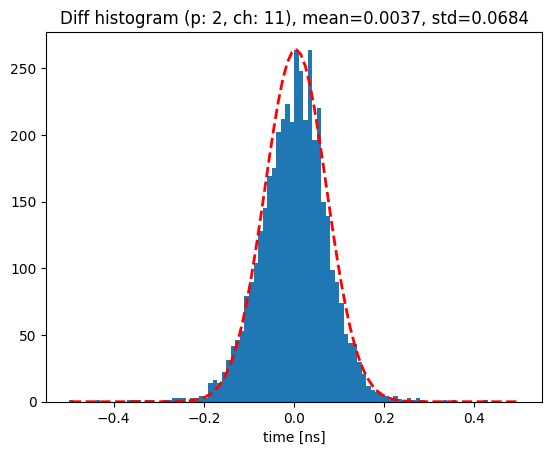

In [16]:
y_pred = model.predict(X_val)[:, 0]
std_2 = plot_difference_hist(y_val, y_pred, PLANE, CHANNEL)

# Convolutional network 1

In [17]:
cnn_1_name = model_name = 'CNN 1'
model = keras.Sequential([
    layers.Input(24),
    layers.Reshape((-1, 1)),
    
    layers.Conv1D(16, 3, padding='same', activation='relu'),
    
    layers.Flatten(),
    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.01, train=False, n_epochs=3000, lr_patience=50, es_patience=400, loss_weights=1000)

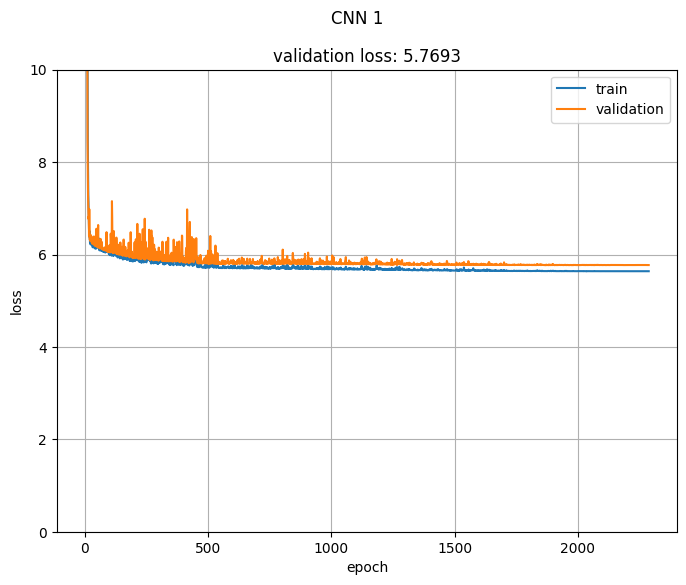

In [18]:
plot_history(history, model_name, ymax=10)

132/132 [==============================] - 2s 1ms/step


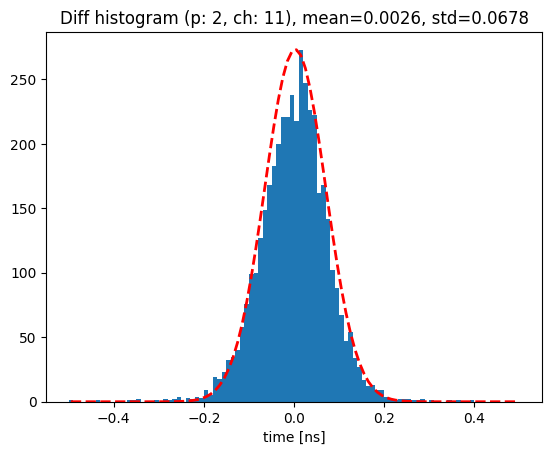

In [19]:
y_pred = model.predict(X_val)[:, 0]
std_3 = plot_difference_hist(y_val, y_pred, PLANE, CHANNEL)

# Convolutional network 2

In [20]:
cnn_2_name = model_name = 'CNN 2'
model = keras.Sequential([
    layers.Input(24),
    layers.Reshape((-1, 1)),
    
    layers.Conv1D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(),
    
    layers.Conv1D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(),
    
    layers.Conv1D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(),
    
    layers.Flatten(),
    layers.Dense(1)
])

history = train_model(model, model_name, lr=0.01, train=False, n_epochs=3000, lr_patience=50, es_patience=400, loss_weights=1000)

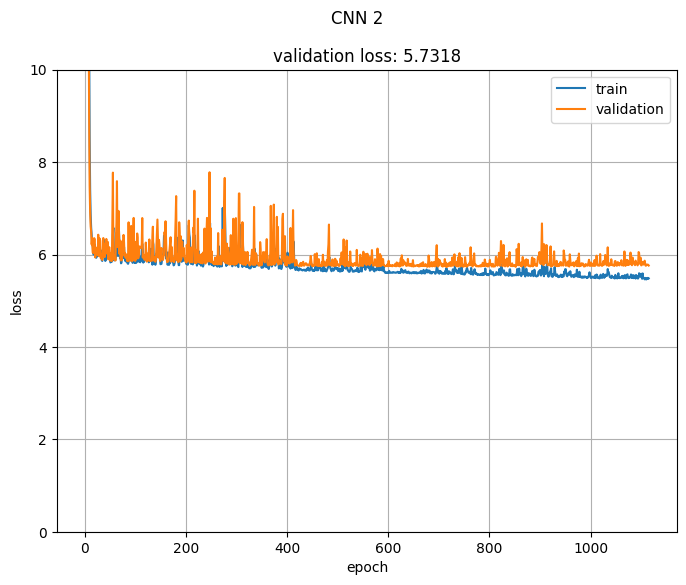

In [21]:
plot_history(history, model_name, ymax=10)

132/132 [==============================] - 0s 1ms/step


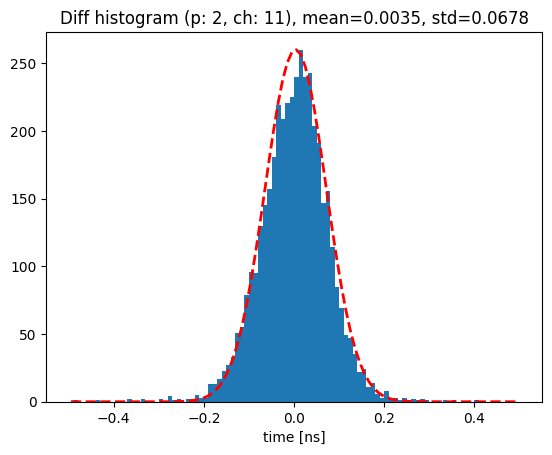

In [22]:
y_pred = model.predict(X_val)[:, 0]
std_4 = plot_difference_hist(y_val, y_pred, PLANE, CHANNEL)

# UNet

In [23]:
def gaussian_kernel(mu, sigma=1., n=24):
    x = np.arange(0, n)
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

get_gauss_stats(np.arange(24), gaussian_kernel(np.array(1.6)))[0]

1.6

In [24]:
Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
Y_heatmap_val = np.array([gaussian_kernel(y) for y in y_val])

In [25]:
unet_name = model_name = 'UNet'

def conv_block(x, n_filters):
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    skip = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D()(skip)
    return skip, x
    
def deconv_block(x, skip, n_filters):
    x = layers.UpSampling1D()(x)
    x = layers.Conv1D(n_filters, 1, activation='linear')(x)
    x = layers.Concatenate()([skip, x])
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    return x
    
    
###################################

inputs = layers.Input(24)
x = layers.Reshape((-1, 1))(inputs)

skip1, x = conv_block(x, 32)
skip2, x = conv_block(x, 64)
skip3, x = conv_block(x, 128)
x, _ = conv_block(x, 256)

x = deconv_block(x, skip3, 128)
x = deconv_block(x, skip2, 64)
x = deconv_block(x, skip1, 32)

x = layers.Conv1D(1, 1, activation='linear')(x)

outputs = layers.Flatten()(x)

model = tf.keras.Model(inputs, outputs)

#############################################

history = train_model(model, model_name, y_train=Y_heatmap_train, y_val=Y_heatmap_val, lr=0.0002, train=False, n_epochs=3000, lr_patience=50, es_patience=400, loss_weights=10000)

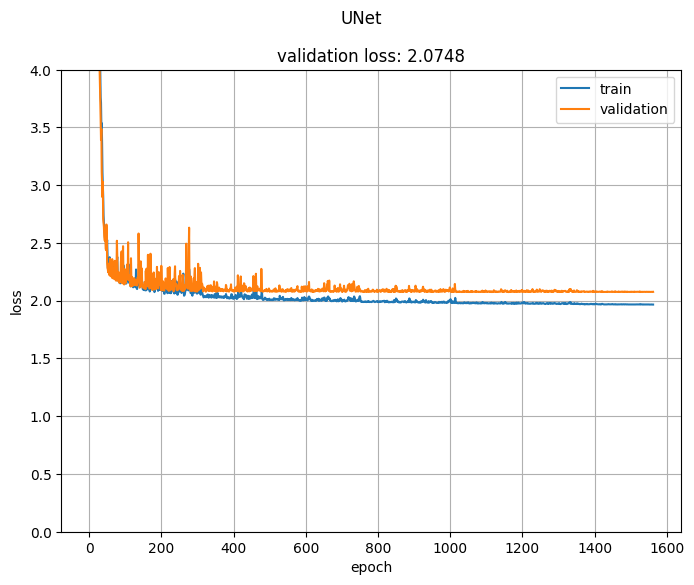

In [26]:
plot_history(history, model_name, ymax=4)

132/132 [==============================] - 1s 5ms/step


C:\Users\MatiX\anaconda3\envs\cern-py310\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)
C:\Users\MatiX\anaconda3\envs\cern-py310\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


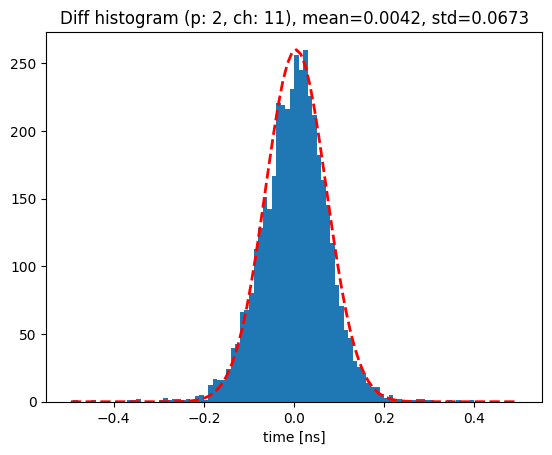

In [27]:
Y_heatmap_pred = model.predict(X_val)

y_pred = np.empty(Y_heatmap_pred.shape[0])
for i, y in enumerate(Y_heatmap_pred):
    y_pred[i] = get_gauss_stats(np.arange(24), y)[0]

std_5 = plot_difference_hist(y_val, y_pred, PLANE, CHANNEL)

# Compare standard deviations

In [28]:
print(f"{'CFD':>10}: {std_cfd * 1000:0.2f} ps")
for i, (std, name) in enumerate(zip([std_1, std_2, std_3, std_4, std_5], [mlp_1_name, mlp_2_name, cnn_1_name, cnn_2_name, unet_name])):
    print(f"{name:>10}: {std * 1000:0.2f} ps (improvement: {(1 - std / std_cfd) * 100:0.2f} %)")

       CFD: 71.56 ps
     MLP 1: 68.49 ps (improvement: 4.29 %)
     MLP 2: 68.42 ps (improvement: 4.39 %)
     CNN 1: 67.77 ps (improvement: 5.29 %)
     CNN 2: 67.85 ps (improvement: 5.19 %)
      UNet: 67.27 ps (improvement: 5.99 %)
